In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from model.cnn import cnn_4layer
from preprocess import water_process

2024-01-02 21:25:26.264122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = water_process(n_hours, k, masked_value, split_1, split_2)

Index(['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2',
       'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26', 'HWS_S25A',
       'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### PM threshold

In [6]:
# train_X_mask_rain_acc = np.sum(train_X_mask[:, -24:, 0], axis=1)
# print(train_X_mask_rain_acc.shape)

# test_X_mask_rain_acc = np.sum(test_X_mask[:, -24:, 0], axis=1)
# print(test_X_mask_rain_acc.shape)

train_X_mask_rain_acc = train_X_mask[:, 0, 0]
print(train_X_mask_rain_acc.shape)

test_X_mask_rain_acc = test_X_mask[:, 0, 0]
print(test_X_mask_rain_acc.shape)

(77069,)
(19268,)


In [7]:
percentile = 95

merged_array = np.concatenate((train_X_mask_rain_acc, test_X_mask_rain_acc))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.01061173528432846


### train_X_filter

In [8]:
train_X_extreme = train_X_mask[train_X_mask_rain_acc > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_ws_y[train_X_mask_rain_acc > percentile_pm]
print(train_y_extreme.shape)

(3678, 96, 16)
(3678, 96)


In [9]:
train_X_normal = train_X_mask[train_X_mask_rain_acc <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_ws_y[train_X_mask_rain_acc <= percentile_pm]
print(train_y_normal.shape)

(73391, 96, 16)
(73391, 96)


### test_X_filter

In [10]:
test_X_extreme = test_X_mask[test_X_mask_rain_acc > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_ws_y[test_X_mask_rain_acc > percentile_pm]
print(test_y_extreme.shape)

(1033, 96, 16)
(1033, 96)


In [11]:
test_X_normal = test_X_mask[test_X_mask_rain_acc <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_ws_y[test_X_mask_rain_acc <= percentile_pm]
print(test_y_normal.shape)

(18235, 96, 16)
(18235, 96)


In [12]:
# Load your dataset
D_f, y_f = train_X_mask[60000:], train_ws_y[60000:]                # Training data (includes both X_rain and X_norm)
# D_f, y_f = train_X_mask, train_ws_y
D_g, y_g = test_X_extreme, test_y_extreme    # Validation data (only X_rain)

In [13]:
D_f.shape

(17069, 96, 16)

### Model

In [14]:
# ===== model parameters ======
cnn_unit1 = 128
cnn_unit2 = 64
cnn_unit3 = 32
cnn_unit4 = 16
dropout = 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-2
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512
opt_num = 96
input_shape = train_X_mask.shape[1:]

In [16]:
# Build your model here
model = cnn_4layer(input_shape=input_shape,
                   cnn_unit1=cnn_unit1,
                   cnn_unit2=cnn_unit2,
                   cnn_unit3=cnn_unit3,
                   cnn_unit4=cnn_unit4,
                   dropout=dropout,
                   kernel_size=kernel_size,
                   pool_size=pool_size,
                   masked_value=-1,
                   opt_num=opt_num,
                  )
# model.summary()

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

# optimizer = Adam(learning_rate=0.01)

In [17]:
# Define the forward function for the model
def forward(model, X, y, weights):
    predictions = model(X, training=True)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions) * weights)
    return loss, predictions


def backward(loss):
    # Compute gradients of loss with respect to model parameters
    gradients = tf.gradients(loss, model.trainable_variables)
    return gradients



# Define the loss function
def calculate_loss(model, X, y, weights):
    predictions = model(X)
    individual_losses = tf.losses.mean_squared_error(y, predictions)  # This gives a loss per sample
    weighted_losses = individual_losses * weights
    return tf.reduce_mean(weighted_losses), individual_losses

In [18]:
# # Define the optimizer for the primary model
# optimizer = Adam(learning_rate=0.01)

# Initialize the example weights wi with ones
# example_weights = tf.ones(shape=(len(D_f)))

sample_weights_IPF = np.load('ws_sample_weights_IPF.npy')
example_weights = tf.convert_to_tensor(sample_weights_IPF, dtype=tf.float32)


# Batch size
batch_size = 64

In [19]:
len(sample_weights_IPF)

17069

In [20]:
# Training loop
for t in range(100):  # Number of iterations
    # Shuffle the training data and example weights at the beginning of each epoch
    indices = np.arange(len(D_f))
    #np.random.shuffle(indices)
    D_f_shuffled = tf.gather(D_f, indices)
    y_f_shuffled = tf.gather(y_f, indices)

    
    example_weights_shuffled = tf.gather(example_weights, indices)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])
    
    
    # Convert example_weights_shuffled back to a tf.Variable if it's not one after tf.gather
    example_weights_shuffled = tf.Variable(example_weights_shuffled)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])

    
    # Iterate over mini-batches
    for i in range(0, len(D_f), batch_size):
        # Slice the mini-batch
        X_batch = D_f_shuffled[i:i+batch_size]
        y_batch = y_f_shuffled[i:i+batch_size]
        w_batch = example_weights_shuffled[i:i+batch_size]

        # Forward pass on the training data with example weights
        with tf.GradientTape() as tape:
            train_loss_f, _ = forward(model, X_batch, y_batch, w_batch)
        gradients_f = tape.gradient(train_loss_f, model.trainable_variables)

        # Apply gradients to update the model parameters
        model.optimizer.apply_gradients(zip(gradients_f, model.trainable_variables))

        
    # After processing all mini-batches, evaluate on validation set
    val_loss_g, val_predictions_g = forward(model, D_g, y_g, tf.ones(shape=(len(D_g), 1)))

    
    # Meta-learning step: Compute the influence of training example weights on validation loss
    with tf.GradientTape() as tape:
        # Re-compute training loss for shuffled data with current model parameters and example weights
        tape.watch(example_weights_shuffled)
        train_loss_f, _ = forward(model, D_f_shuffled, y_f_shuffled, example_weights_shuffled)

        
    # Now compute gradients of this loss w.r.t. the example weights
    example_weight_gradients = tape.gradient(train_loss_f, example_weights_shuffled)
    
    
    # Adjust example weights based on gradients: This is a simplistic approach; actual update rule may differ
    example_weight_updates = -0.01 * example_weight_gradients
    
    
    # Apply updates to the example weights
    example_weights_shuffled.assign_add(example_weight_updates)
    
    # Ensure example_weights remain non-negative and re-normalize
    example_weights_shuffled.assign(tf.maximum(example_weights_shuffled, 0))
    example_weights_shuffled.assign(example_weights_shuffled / tf.reduce_sum(example_weights_shuffled))
    
    
    # Update the original example weights
    indices_matrix = tf.reshape(indices, (len(indices), 1)) 
    example_weights = tf.tensor_scatter_nd_update(example_weights, indices_matrix, example_weights_shuffled)
    print("example_weights:", example_weights[:3])
    

    
    # Log the progress
    print(f'Epoch {t+1}: Training Loss = {train_loss_f.numpy():.6f}, Validation Loss = {val_loss_g.numpy():.6f} \n')

2024-01-02 21:25:57.622062: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-02 21:25:58.721442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


example_weights: tf.Tensor([4.6264566e-05 4.6267101e-05 4.6277532e-05], shape=(3,), dtype=float32)
Epoch 1: Training Loss = 0.000001, Validation Loss = 0.239732 

example_weights: tf.Tensor([4.6264675e-05 4.6266832e-05 4.6277415e-05], shape=(3,), dtype=float32)
Epoch 2: Training Loss = 0.000001, Validation Loss = 0.030311 

example_weights: tf.Tensor([4.6264588e-05 4.6266909e-05 4.6277401e-05], shape=(3,), dtype=float32)
Epoch 3: Training Loss = 0.000001, Validation Loss = 0.029080 

example_weights: tf.Tensor([4.6264573e-05 4.6267138e-05 4.6277451e-05], shape=(3,), dtype=float32)
Epoch 4: Training Loss = 0.000001, Validation Loss = 0.028011 

example_weights: tf.Tensor([4.6264653e-05 4.6267724e-05 4.6277659e-05], shape=(3,), dtype=float32)
Epoch 5: Training Loss = 0.000001, Validation Loss = 0.026654 

example_weights: tf.Tensor([4.6264719e-05 4.6268142e-05 4.6277884e-05], shape=(3,), dtype=float32)
Epoch 6: Training Loss = 0.000001, Validation Loss = 0.024357 

example_weights: tf.Te

example_weights: tf.Tensor([4.6231802e-05 4.6238503e-05 4.6242960e-05], shape=(3,), dtype=float32)
Epoch 52: Training Loss = 0.000000, Validation Loss = 0.002641 

example_weights: tf.Tensor([4.6231595e-05 4.6238300e-05 4.6241748e-05], shape=(3,), dtype=float32)
Epoch 53: Training Loss = 0.000000, Validation Loss = 0.002607 

example_weights: tf.Tensor([4.6231311e-05 4.6237914e-05 4.6241319e-05], shape=(3,), dtype=float32)
Epoch 54: Training Loss = 0.000000, Validation Loss = 0.002631 

example_weights: tf.Tensor([4.6231304e-05 4.6237852e-05 4.6241290e-05], shape=(3,), dtype=float32)
Epoch 55: Training Loss = 0.000000, Validation Loss = 0.002641 

example_weights: tf.Tensor([4.6231009e-05 4.6237637e-05 4.6241006e-05], shape=(3,), dtype=float32)
Epoch 56: Training Loss = 0.000000, Validation Loss = 0.002571 

example_weights: tf.Tensor([4.6230743e-05 4.6237205e-05 4.6240955e-05], shape=(3,), dtype=float32)
Epoch 57: Training Loss = 0.000000, Validation Loss = 0.002593 

example_weights:

In [23]:
example_weights

<tf.Tensor: shape=(30000,), dtype=float32, numpy=
array([2.4996085e-05, 2.4989513e-05, 2.4977113e-05, ..., 2.5053163e-05,
       2.5052519e-05, 2.5050571e-05], dtype=float32)>

(array([2.9779e+04, 1.3900e+02, 3.7000e+01, 2.7000e+01, 0.0000e+00,
        0.0000e+00, 4.0000e+00, 7.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.47890493e-05, 3.68958659e-04, 7.13128247e-04, 1.05729781e-03,
        1.40146748e-03, 1.74563704e-03, 2.08980660e-03, 2.43397639e-03,
        2.77814595e-03, 3.12231551e-03, 3.46648507e-03, 3.81065463e-03,
        4.15482419e-03, 4.49899398e-03, 4.84316330e-03, 5.18733310e-03,
        5.53150289e-03, 5.87567221e-03, 6.21984201e-03, 6.56401133e-03,
        6.90818112e-03]),
 <BarContainer object of 20 artists>)

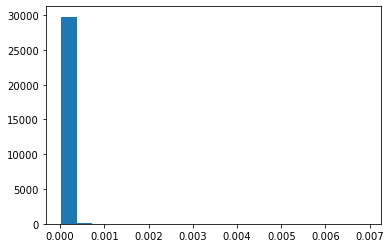

In [24]:
plt.hist(example_weights.numpy(), bins=20)

In [39]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/ws_all_weighted_META.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=example_weights
         )

Epoch 1/3000
151/151 - 2s - loss: 9.1268e-09 - mae: 0.0143 - val_loss: 0.0020 - val_mae: 0.0349

Epoch 00001: val_mae improved from inf to 0.03488, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 2/3000
151/151 - 1s - loss: 9.0851e-09 - mae: 0.0142 - val_loss: 0.0019 - val_mae: 0.0348

Epoch 00002: val_mae improved from 0.03488 to 0.03476, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 3/3000
151/151 - 1s - loss: 9.0596e-09 - mae: 0.0142 - val_loss: 0.0019 - val_mae: 0.0346

Epoch 00003: val_mae improved from 0.03476 to 0.03463, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 4/3000
151/151 - 1s - loss: 9.0696e-09 - mae: 0.0142 - val_loss: 0.0019 - val_mae: 0.0346

Epoch 00004: val_mae did not improve from 0.03463
Epoch 5/3000
151/151 - 1s - loss: 9.0466e-09 - mae: 0.0141 - val_loss: 0.0019 - val_mae: 0.0345

Epoch 00005: val_mae improved from 0.03463 to 0.03452, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 6/3000



Epoch 00048: val_mae did not improve from 0.03334
Epoch 49/3000
151/151 - 1s - loss: 8.8837e-09 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0333

Epoch 00049: val_mae did not improve from 0.03334
Epoch 50/3000
151/151 - 1s - loss: 8.8984e-09 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0333

Epoch 00050: val_mae improved from 0.03334 to 0.03334, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 51/3000
151/151 - 1s - loss: 8.8746e-09 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0335

Epoch 00051: val_mae did not improve from 0.03334
Epoch 52/3000
151/151 - 1s - loss: 8.8797e-09 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0334

Epoch 00052: val_mae did not improve from 0.03334
Epoch 53/3000
151/151 - 1s - loss: 8.8430e-09 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0335

Epoch 00053: val_mae did not improve from 0.03334
Epoch 54/3000
151/151 - 1s - loss: 8.8430e-09 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0334

Epoch 00054: val_mae did not improve from 0.033

151/151 - 1s - loss: 8.7795e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0332

Epoch 00102: val_mae did not improve from 0.03315
Epoch 103/3000
151/151 - 1s - loss: 8.7701e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0334

Epoch 00103: val_mae did not improve from 0.03315
Epoch 104/3000
151/151 - 1s - loss: 8.7505e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0332

Epoch 00104: val_mae did not improve from 0.03315
Epoch 105/3000
151/151 - 1s - loss: 8.7652e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0333

Epoch 00105: val_mae did not improve from 0.03315
Epoch 106/3000
151/151 - 1s - loss: 8.7465e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0333

Epoch 00106: val_mae did not improve from 0.03315
Epoch 107/3000
151/151 - 1s - loss: 8.7540e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0333

Epoch 00107: val_mae did not improve from 0.03315
Epoch 108/3000
151/151 - 1s - loss: 8.7552e-09 - mae: 0.0138 - val_loss: 0.0018 - val_mae: 0.0333

Epoch 00108: val_mae d

151/151 - 1s - loss: 8.6489e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0330

Epoch 00156: val_mae did not improve from 0.03299
Epoch 157/3000
151/151 - 1s - loss: 8.6694e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0331

Epoch 00157: val_mae did not improve from 0.03299
Epoch 158/3000
151/151 - 1s - loss: 8.6644e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0331

Epoch 00158: val_mae did not improve from 0.03299
Epoch 159/3000
151/151 - 1s - loss: 8.6466e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0330

Epoch 00159: val_mae did not improve from 0.03299
Epoch 160/3000
151/151 - 1s - loss: 8.6530e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0330

Epoch 00160: val_mae did not improve from 0.03299
Epoch 161/3000
151/151 - 1s - loss: 8.6710e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0331

Epoch 00161: val_mae did not improve from 0.03299
Epoch 162/3000
151/151 - 1s - loss: 8.6642e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0331

Epoch 00162: val_mae d


Epoch 00209: val_mae improved from 0.03286 to 0.03282, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 210/3000
151/151 - 1s - loss: 8.5895e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0329

Epoch 00210: val_mae did not improve from 0.03282
Epoch 211/3000
151/151 - 1s - loss: 8.5996e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0330

Epoch 00211: val_mae did not improve from 0.03282
Epoch 212/3000
151/151 - 1s - loss: 8.5857e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0329

Epoch 00212: val_mae did not improve from 0.03282
Epoch 213/3000
151/151 - 1s - loss: 8.5872e-09 - mae: 0.0137 - val_loss: 0.0017 - val_mae: 0.0329

Epoch 00213: val_mae did not improve from 0.03282
Epoch 214/3000
151/151 - 1s - loss: 8.5774e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0329

Epoch 00214: val_mae did not improve from 0.03282
Epoch 215/3000
151/151 - 1s - loss: 8.5761e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0330

Epoch 00215: val_mae did not improve from


Epoch 00263: val_mae did not improve from 0.03270
Epoch 264/3000
151/151 - 1s - loss: 8.5025e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0329

Epoch 00264: val_mae did not improve from 0.03270
Epoch 265/3000
151/151 - 1s - loss: 8.5081e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00265: val_mae did not improve from 0.03270
Epoch 266/3000
151/151 - 1s - loss: 8.4778e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00266: val_mae did not improve from 0.03270
Epoch 267/3000
151/151 - 1s - loss: 8.5219e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00267: val_mae did not improve from 0.03270
Epoch 268/3000
151/151 - 1s - loss: 8.5365e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0330

Epoch 00268: val_mae did not improve from 0.03270
Epoch 269/3000
151/151 - 1s - loss: 8.5005e-09 - mae: 0.0136 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00269: val_mae did not improve from 0.03270
Epoch 270/3000
151/151 - 1s - loss: 8.5149e-09 - mae: 0

151/151 - 1s - loss: 8.4253e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00318: val_mae did not improve from 0.03266
Epoch 319/3000
151/151 - 1s - loss: 8.4470e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00319: val_mae did not improve from 0.03266
Epoch 320/3000
151/151 - 1s - loss: 8.4576e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00320: val_mae did not improve from 0.03266
Epoch 321/3000
151/151 - 1s - loss: 8.4299e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00321: val_mae did not improve from 0.03266
Epoch 322/3000
151/151 - 1s - loss: 8.4283e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0327

Epoch 00322: val_mae did not improve from 0.03266
Epoch 323/3000
151/151 - 1s - loss: 8.4208e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0327

Epoch 00323: val_mae did not improve from 0.03266
Epoch 324/3000
151/151 - 1s - loss: 8.4254e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00324: val_mae d


Epoch 00370: val_mae did not improve from 0.03251
Epoch 371/3000
151/151 - 1s - loss: 8.3701e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0327

Epoch 00371: val_mae did not improve from 0.03251
Epoch 372/3000
151/151 - 1s - loss: 8.4028e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0327

Epoch 00372: val_mae did not improve from 0.03251
Epoch 373/3000
151/151 - 1s - loss: 8.3876e-09 - mae: 0.0135 - val_loss: 0.0017 - val_mae: 0.0329

Epoch 00373: val_mae did not improve from 0.03251
Epoch 374/3000
151/151 - 1s - loss: 8.3395e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0326

Epoch 00374: val_mae did not improve from 0.03251
Epoch 375/3000
151/151 - 1s - loss: 8.3685e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0326

Epoch 00375: val_mae did not improve from 0.03251
Epoch 376/3000
151/151 - 1s - loss: 8.3809e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0328

Epoch 00376: val_mae did not improve from 0.03251
Epoch 377/3000
151/151 - 1s - loss: 8.3496e-09 - mae: 0

151/151 - 1s - loss: 8.2983e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0325

Epoch 00423: val_mae did not improve from 0.03237
Epoch 424/3000
151/151 - 1s - loss: 8.2970e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0325

Epoch 00424: val_mae did not improve from 0.03237
Epoch 425/3000
151/151 - 1s - loss: 8.2832e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0324

Epoch 00425: val_mae did not improve from 0.03237
Epoch 426/3000
151/151 - 1s - loss: 8.2975e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0327

Epoch 00426: val_mae did not improve from 0.03237
Epoch 427/3000
151/151 - 1s - loss: 8.2966e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0324

Epoch 00427: val_mae did not improve from 0.03237
Epoch 428/3000
151/151 - 1s - loss: 8.2879e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0325

Epoch 00428: val_mae did not improve from 0.03237
Epoch 429/3000
151/151 - 1s - loss: 8.2867e-09 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0326

Epoch 00429: val_mae d

151/151 - 1s - loss: 8.2115e-09 - mae: 0.0133 - val_loss: 0.0017 - val_mae: 0.0324

Epoch 00477: val_mae did not improve from 0.03235
Epoch 478/3000
151/151 - 1s - loss: 8.2312e-09 - mae: 0.0133 - val_loss: 0.0017 - val_mae: 0.0325

Epoch 00478: val_mae did not improve from 0.03235
Epoch 479/3000
151/151 - 1s - loss: 8.2291e-09 - mae: 0.0133 - val_loss: 0.0017 - val_mae: 0.0324

Epoch 00479: val_mae did not improve from 0.03235
Epoch 480/3000
151/151 - 1s - loss: 8.2151e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0324

Epoch 00480: val_mae did not improve from 0.03235
Epoch 481/3000
151/151 - 1s - loss: 8.2131e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0324

Epoch 00481: val_mae did not improve from 0.03235
Epoch 482/3000
151/151 - 1s - loss: 8.2379e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0323

Epoch 00482: val_mae improved from 0.03235 to 0.03231, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 483/3000
151/151 - 1s - loss: 8.2199e-09 - mae: 0.0


Epoch 00530: val_mae did not improve from 0.03222
Epoch 531/3000
151/151 - 1s - loss: 8.1605e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0323

Epoch 00531: val_mae did not improve from 0.03222
Epoch 532/3000
151/151 - 1s - loss: 8.1608e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0324

Epoch 00532: val_mae did not improve from 0.03222
Epoch 533/3000
151/151 - 1s - loss: 8.1726e-09 - mae: 0.0133 - val_loss: 0.0017 - val_mae: 0.0325

Epoch 00533: val_mae did not improve from 0.03222
Epoch 534/3000
151/151 - 1s - loss: 8.1637e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0323

Epoch 00534: val_mae did not improve from 0.03222
Epoch 535/3000
151/151 - 1s - loss: 8.1215e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0324

Epoch 00535: val_mae did not improve from 0.03222
Epoch 536/3000
151/151 - 1s - loss: 8.1497e-09 - mae: 0.0133 - val_loss: 0.0016 - val_mae: 0.0323

Epoch 00536: val_mae did not improve from 0.03222
Epoch 537/3000
151/151 - 1s - loss: 8.1159e-09 - mae: 0

151/151 - 1s - loss: 8.1177e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00585: val_mae improved from 0.03215 to 0.03213, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 586/3000
151/151 - 1s - loss: 8.0939e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0322

Epoch 00586: val_mae did not improve from 0.03213
Epoch 587/3000
151/151 - 1s - loss: 8.1023e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00587: val_mae improved from 0.03213 to 0.03210, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 588/3000
151/151 - 1s - loss: 8.0922e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0323

Epoch 00588: val_mae did not improve from 0.03210
Epoch 589/3000
151/151 - 1s - loss: 8.0835e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0322

Epoch 00589: val_mae did not improve from 0.03210
Epoch 590/3000
151/151 - 1s - loss: 8.0630e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0322

Epoch 00590: val_mae did not improve from 0

151/151 - 1s - loss: 7.9929e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00638: val_mae did not improve from 0.03206
Epoch 639/3000
151/151 - 1s - loss: 8.0545e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00639: val_mae did not improve from 0.03206
Epoch 640/3000
151/151 - 1s - loss: 8.0233e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0322

Epoch 00640: val_mae did not improve from 0.03206
Epoch 641/3000
151/151 - 1s - loss: 8.0372e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0322

Epoch 00641: val_mae did not improve from 0.03206
Epoch 642/3000
151/151 - 1s - loss: 8.0163e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00642: val_mae did not improve from 0.03206
Epoch 643/3000
151/151 - 1s - loss: 8.0383e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00643: val_mae did not improve from 0.03206
Epoch 644/3000
151/151 - 1s - loss: 8.0304e-09 - mae: 0.0132 - val_loss: 0.0016 - val_mae: 0.0322

Epoch 00644: val_mae d


Epoch 00692: val_mae did not improve from 0.03201
Epoch 693/3000
151/151 - 1s - loss: 7.9455e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00693: val_mae did not improve from 0.03201
Epoch 694/3000
151/151 - 1s - loss: 7.9736e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0319

Epoch 00694: val_mae improved from 0.03201 to 0.03189, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 695/3000
151/151 - 1s - loss: 7.9607e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0321

Epoch 00695: val_mae did not improve from 0.03189
Epoch 696/3000
151/151 - 1s - loss: 7.9770e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00696: val_mae did not improve from 0.03189
Epoch 697/3000
151/151 - 1s - loss: 7.9684e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00697: val_mae did not improve from 0.03189
Epoch 698/3000
151/151 - 1s - loss: 7.9596e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00698: val_mae did not improve from


Epoch 00746: val_mae did not improve from 0.03184
Epoch 747/3000
151/151 - 1s - loss: 7.8932e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00747: val_mae did not improve from 0.03184
Epoch 748/3000
151/151 - 1s - loss: 7.9145e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00748: val_mae did not improve from 0.03184
Epoch 749/3000
151/151 - 1s - loss: 7.8786e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0319

Epoch 00749: val_mae did not improve from 0.03184
Epoch 750/3000
151/151 - 1s - loss: 7.9048e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00750: val_mae did not improve from 0.03184
Epoch 751/3000
151/151 - 1s - loss: 7.9295e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00751: val_mae did not improve from 0.03184
Epoch 752/3000
151/151 - 1s - loss: 7.9001e-09 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00752: val_mae did not improve from 0.03184
Epoch 753/3000
151/151 - 1s - loss: 7.8948e-09 - mae: 0

151/151 - 1s - loss: 7.8553e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00801: val_mae improved from 0.03181 to 0.03180, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 802/3000
151/151 - 1s - loss: 7.8674e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0319

Epoch 00802: val_mae did not improve from 0.03180
Epoch 803/3000
151/151 - 1s - loss: 7.8363e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00803: val_mae did not improve from 0.03180
Epoch 804/3000
151/151 - 1s - loss: 7.8528e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0319

Epoch 00804: val_mae did not improve from 0.03180
Epoch 805/3000
151/151 - 1s - loss: 7.8409e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0319

Epoch 00805: val_mae did not improve from 0.03180
Epoch 806/3000
151/151 - 1s - loss: 7.8576e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0320

Epoch 00806: val_mae did not improve from 0.03180
Epoch 807/3000
151/151 - 1s - loss: 7.8396e-09 - mae: 0.0


Epoch 00853: val_mae did not improve from 0.03171
Epoch 854/3000
151/151 - 1s - loss: 7.7870e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00854: val_mae improved from 0.03171 to 0.03170, saving model to ../../saved_models/ws_all_weighted_META.h5
Epoch 855/3000
151/151 - 1s - loss: 7.7785e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00855: val_mae did not improve from 0.03170
Epoch 856/3000
151/151 - 1s - loss: 7.8056e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00856: val_mae did not improve from 0.03170
Epoch 857/3000
151/151 - 1s - loss: 7.7783e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00857: val_mae did not improve from 0.03170
Epoch 858/3000
151/151 - 1s - loss: 7.8248e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0319

Epoch 00858: val_mae did not improve from 0.03170
Epoch 859/3000
151/151 - 1s - loss: 7.7849e-09 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00859: val_mae did not improve from


Epoch 00907: val_mae did not improve from 0.03159
Epoch 908/3000
151/151 - 1s - loss: 7.7519e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00908: val_mae did not improve from 0.03159
Epoch 909/3000
151/151 - 1s - loss: 7.7655e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0318

Epoch 00909: val_mae did not improve from 0.03159
Epoch 910/3000
151/151 - 1s - loss: 7.7384e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0316

Epoch 00910: val_mae did not improve from 0.03159
Epoch 911/3000
151/151 - 1s - loss: 7.7223e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00911: val_mae did not improve from 0.03159
Epoch 912/3000
151/151 - 1s - loss: 7.7156e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00912: val_mae did not improve from 0.03159
Epoch 913/3000
151/151 - 1s - loss: 7.7123e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00913: val_mae did not improve from 0.03159
Epoch 914/3000
151/151 - 1s - loss: 7.7146e-09 - mae: 0

151/151 - 1s - loss: 7.6675e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00961: val_mae did not improve from 0.03153
Epoch 962/3000
151/151 - 1s - loss: 7.6764e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0316

Epoch 00962: val_mae did not improve from 0.03153
Epoch 963/3000
151/151 - 1s - loss: 7.6928e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0315

Epoch 00963: val_mae did not improve from 0.03153
Epoch 964/3000
151/151 - 1s - loss: 7.6902e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0316

Epoch 00964: val_mae did not improve from 0.03153
Epoch 965/3000
151/151 - 1s - loss: 7.6822e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0317

Epoch 00965: val_mae did not improve from 0.03153
Epoch 966/3000
151/151 - 1s - loss: 7.6682e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0316

Epoch 00966: val_mae did not improve from 0.03153
Epoch 967/3000
151/151 - 1s - loss: 7.6897e-09 - mae: 0.0129 - val_loss: 0.0016 - val_mae: 0.0316

Epoch 00967: val_mae d

KeyboardInterrupt: 